# FEATURE SELECTION

# Setup

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


change to proper directory

In [5]:
emotionsDF = pd.read_csv('Merged Emotions Data.csv')

In [17]:
emotionsDF['mood'] = emotionsDF['mood'].astype('category')

In [22]:
emotionsDF['genre'] = emotionsDF['genre'].astype('category')

In [24]:
emotionsDF.dtypes

danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
uri                   object
duration_ms            int64
time_signature         int64
song                  object
mood                category
genre               category
dtype: object

# General Correlation Matrix

In [50]:
mood_codes, mood_categories = pd.factorize(emotionsDF['mood'])
factorizedEmotionsDF = emotionsDF.copy()
# add a new column 'mood_code' to df with the numerical codes for the mood values
factorizedEmotionsDF['mood_code'] = mood_codes


<ipython-input-51-d5e906ebfd58>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = factorizedEmotionsDF.corr()


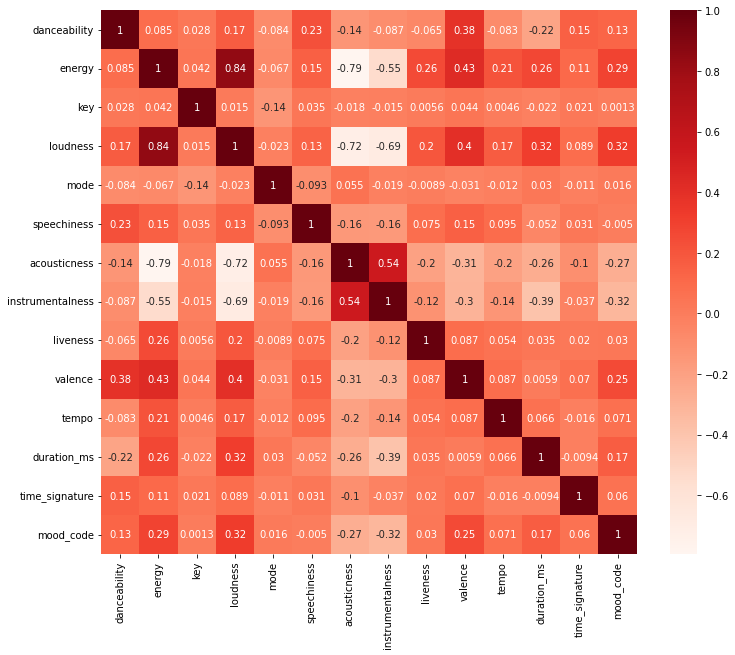

In [51]:
plt.figure(figsize=(12,10))

cor = factorizedEmotionsDF.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Correlation Matrix on Affect

<ipython-input-53-abd13c2438df>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_encoded.corr()


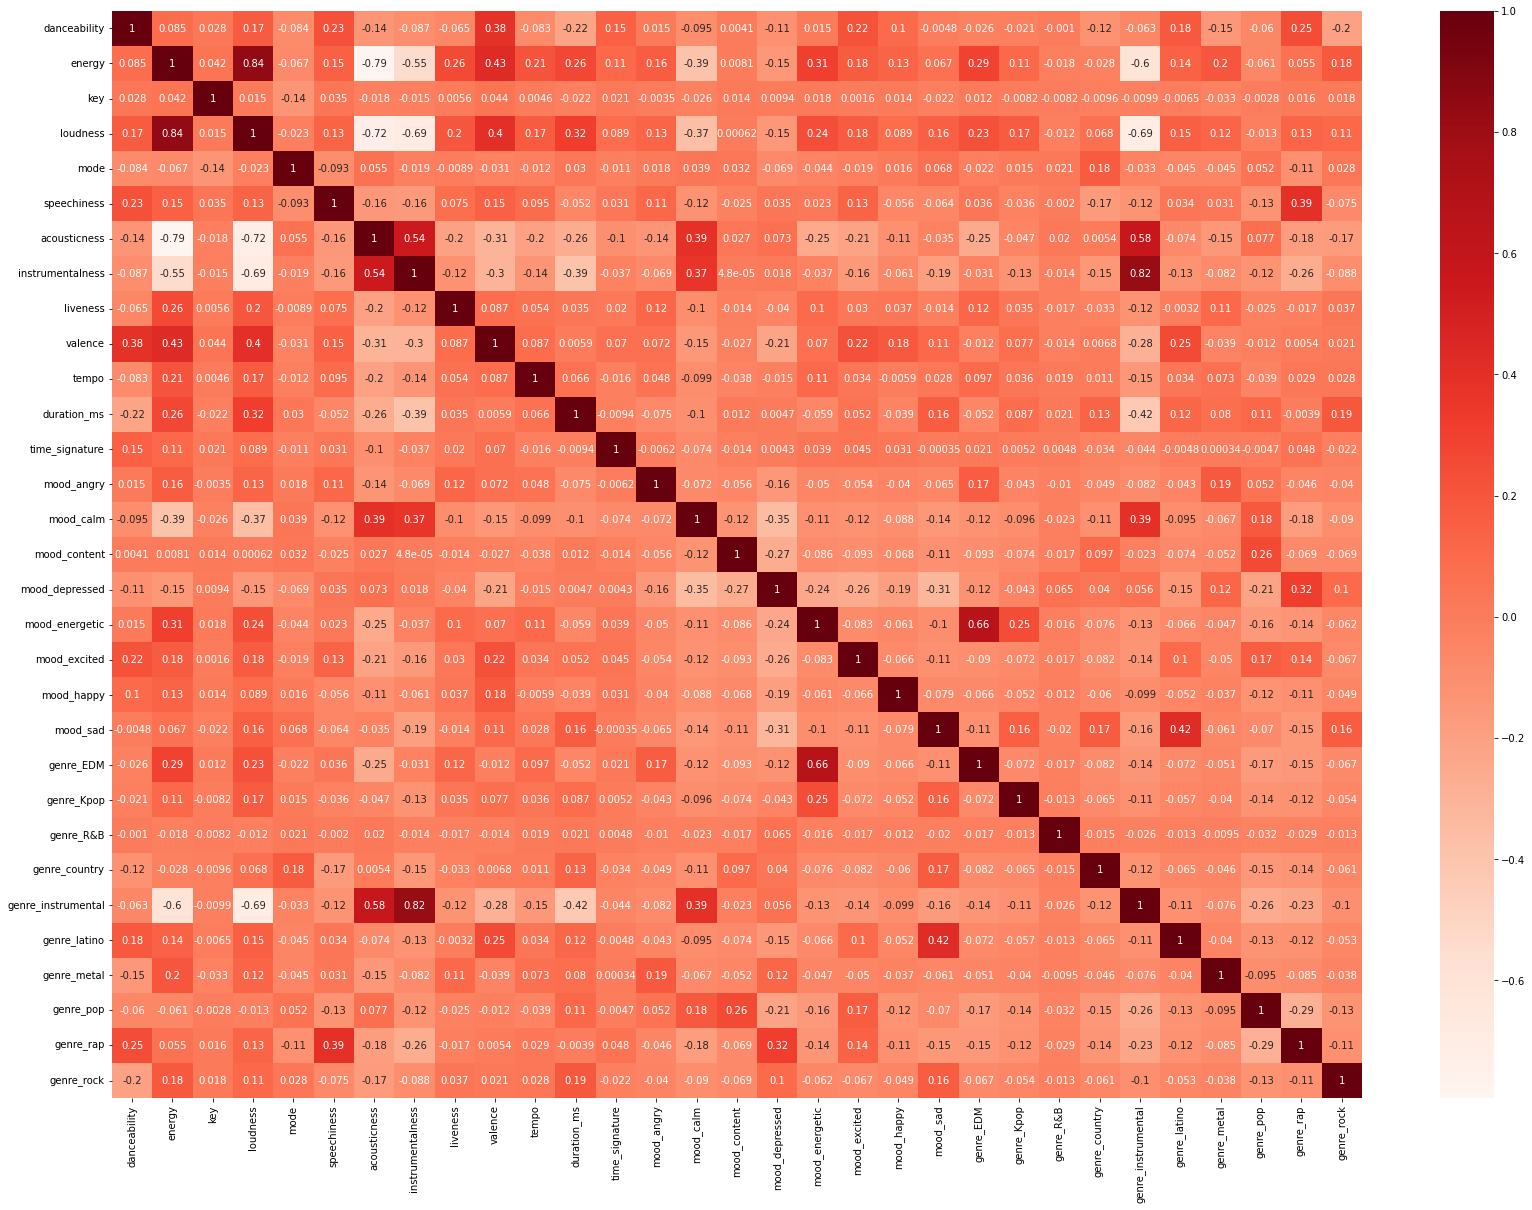

In [53]:
#determine which variables are the most important for predicting the target variable
plt.figure(figsize=(28,20))


df_encoded = pd.get_dummies(emotionsDF, columns=['mood', 'genre'])

# Calculate correlation matrix
cor = df_encoded.corr()

sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


# Recap

In general, valence and energy are the most correlated with the mood, which makes sense as that is how we generally derive moods in the mood identification.  Loudness and energy also higly correlate, which makes sense as they both seem to be an indicator of each other. Th only features with negative correlation are the acousticness and instrumentalness, however, they do have high correlation for the calm moods.  I think we can first keep all the features and then potentially remove some of the features later like the acousticness and instrumentalness, and maybe the loudness.

# Data Transformation
Here we will transform the data to be more suitable for the model.  We will use the StandardScaler to scale the data to have a mean of 0 and a standard deviation of 1.  We will also use the MinMaxScaler to scale the data to be between 0 and 1.  We will use the StandardScaler for the MLP model and the MinMaxScaler for the SVM model.

In [75]:
factorizedEmotionsDF.head(1)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,song,mood,genre,mood_code
0,0.548,0.833,7,-3.294,1,0.0497,0.199,0.0,0.305,0.467,190.029,spotify:track:6dDIOU6AqgLkrjFNPgvKY6,229693,3,FU (feat. French Montana),angry,pop,0


In [85]:
factorizedEmotionsDF.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,mood_code
count,8837.000000,8837.000000,8837.000000,8837.000000,8837.000000,8837.000000,8837.000000,8837.000000,8837.000000,8837.000000,8837.000000,8837.000000,8837.000000,8837.000000
mean,0.611344,0.547393,5.229942,-8.979625,0.606428,0.096084,0.365294,0.195646,0.169575,0.386293,121.009138,195002.361774,3.933688,3.377504
std,0.149818,0.255836,3.563159,5.456196,0.488570,0.100840,0.346382,0.351318,0.127873,0.226490,30.329310,57745.484187,0.362506,1.854992
min,0.000000,0.002760,0.000000,-38.986000,0.000000,0.000000,0.000003,0.000000,0.015000,0.000000,0.000000,33787.000000,0.000000,0.000000
25%,0.514000,0.350000,2.000000,-11.295000,0.000000,0.036000,0.043100,0.000000,0.098800,0.203000,95.881000,154483.000000,4.000000,2.000000
50%,0.623000,0.570000,5.000000,-7.388000,1.000000,0.052100,0.237000,0.000031,0.117000,0.355000,122.004000,193400.000000,4.000000,3.000000
75%,0.721000,0.756000,8.000000,-5.146000,1.000000,0.108000,0.699000,0.136000,0.189000,0.540000,141.964000,227235.000000,4.000000,4.000000
max,0.966000,0.998000,11.000000,3.010000,1.000000,0.869000,0.996000,0.986000,0.970000,0.979000,214.413000,595760.000000,5.000000,7.000000


In [87]:
#clip outliers to 1st and 99th percentile
factorizedEmotionsDF['danceability'] = factorizedEmotionsDF['danceability'].clip(lower=factorizedEmotionsDF['danceability'].quantile(0.01), upper=factorizedEmotionsDF['danceability'].quantile(0.99))
factorizedEmotionsDF['energy'] = factorizedEmotionsDF['energy'].clip(lower=factorizedEmotionsDF['energy'].quantile(0.01), upper=factorizedEmotionsDF['energy'].quantile(0.99))
factorizedEmotionsDF['loudness'] = factorizedEmotionsDF['loudness'].clip(lower=factorizedEmotionsDF['loudness'].quantile(0.01), upper=factorizedEmotionsDF['loudness'].quantile(0.99))
factorizedEmotionsDF['speechiness'] = factorizedEmotionsDF['speechiness'].clip(lower=factorizedEmotionsDF['speechiness'].quantile(0.01), upper=factorizedEmotionsDF['speechiness'].quantile(0.99))
factorizedEmotionsDF['acousticness'] = factorizedEmotionsDF['acousticness'].clip(lower=factorizedEmotionsDF['acousticness'].quantile(0.01), upper=factorizedEmotionsDF['acousticness'].quantile(0.99))
factorizedEmotionsDF['instrumentalness'] = factorizedEmotionsDF['instrumentalness'].clip(lower=factorizedEmotionsDF['instrumentalness'].quantile(0.01), upper=factorizedEmotionsDF['instrumentalness'].quantile(0.99))
factorizedEmotionsDF['liveness'] = factorizedEmotionsDF['liveness'].clip(lower=factorizedEmotionsDF['liveness'].quantile(0.01), upper=factorizedEmotionsDF['liveness'].quantile(0.99))
factorizedEmotionsDF['valence'] = factorizedEmotionsDF['valence'].clip(lower=factorizedEmotionsDF['valence'].quantile(0.01), upper=factorizedEmotionsDF['valence'].quantile(0.99))
factorizedEmotionsDF['tempo'] = factorizedEmotionsDF['tempo'].clip(lower=factorizedEmotionsDF['tempo'].quantile(0.01), upper=factorizedEmotionsDF['tempo'].quantile(0.99))
factorizedEmotionsDF['duration_ms'] = factorizedEmotionsDF['duration_ms'].clip(lower=factorizedEmotionsDF['duration_ms'].quantile(0.01), upper=factorizedEmotionsDF['duration_ms'].quantile(0.99))
factorizedEmotionsDF['time_signature'] = factorizedEmotionsDF['time_signature'].clip(lower=factorizedEmotionsDF['time_signature'].quantile(0.01), upper=factorizedEmotionsDF['time_signature'].quantile(0.99))



In [88]:
songInfoDF = factorizedEmotionsDF[['uri', 'song',  'genre','mood']]

In [89]:
y = factorizedEmotionsDF['mood_code']

In [90]:
y.value_counts()

3    3783
1    1218
7    1020
2     773
5     728
4     631
6     405
0     279
Name: mood_code, dtype: int64

In [91]:
X_raw = factorizedEmotionsDF.drop(['uri', 'song',  'genre','mood_code','mood'], axis=1)

# Scaling For MLP

In [92]:
scaler = StandardScaler()
X_scaledStandard = scaler.fit_transform(X_raw)

In [94]:
X_scaledStandardDF = pd.DataFrame(X_scaledStandard, columns=X_raw.columns)

In [95]:
X_scaledStandardDF.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,8.837000e+03,8.837000e+03,8.837000e+03,8.837000e+03,8.837000e+03,8.837000e+03,8.837000e+03,8.837000e+03,8.837000e+03,8.837000e+03,8.837000e+03,8.837000e+03,8.837000e+03
mean,7.944056e-16,-3.087568e-16,1.041250e-16,-8.362164e-17,-5.145947e-17,1.785000e-16,3.216217e-17,-5.145947e-17,8.040542e-19,2.058379e-16,5.475609e-16,-5.338920e-16,7.075677e-16
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00
min,-2.598634e+00,-2.004738e+00,-1.467866e+00,-3.278064e+00,-1.241301e+00,-7.180675e-01,-1.054539e+00,-5.569624e-01,-9.714152e-01,-1.540645e+00,-1.909091e+00,-1.916710e+00,-3.298001e+00
25%,-6.599874e-01,-7.731143e-01,-9.065341e-01,-4.361323e-01,-1.241301e+00,-6.117060e-01,-9.303142e-01,-5.569624e-01,-5.689795e-01,-8.107628e-01,-8.372426e-01,-7.236710e-01,1.873416e-01
50%,7.675735e-02,8.832278e-02,-6.453692e-02,2.942048e-01,8.056064e-01,-4.454515e-01,-3.703639e-01,-5.568733e-01,-4.207138e-01,-1.375700e-01,3.454408e-02,-2.251132e-02,1.873416e-01
75%,7.391517e-01,8.166287e-01,7.774602e-01,7.133028e-01,8.056064e-01,1.317922e-01,9.638136e-01,-1.696643e-01,1.658322e-01,6.817765e-01,7.006568e-01,5.870870e-01,1.873416e-01
max,1.989590e+00,1.685897e+00,1.619457e+00,1.375861e+00,8.056064e-01,3.832860e+00,1.799579e+00,2.165515e+00,4.304240e+00,2.378045e+00,2.237103e+00,3.201400e+00,3.672684e+00


In [106]:
X_train_standard, X_test_standard, y_train_standard, y_test_standard = train_test_split(X_scaledStandard, y, test_size=0.2, random_state=42, stratify=y)


# Training MLP Model and Testing on Validation Set

In [104]:

# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(64, 32))

## Testing with unbalanced data

In [107]:
# Train the model on the resampled data
mlp.fit(X_train_standard, y_train_standard)

# Make predictions on the test set
y_pred = mlp.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.12      0.18        56
           1       0.55      0.44      0.49       244
           2       0.38      0.17      0.23       155
           3       0.56      0.78      0.65       757
           4       0.55      0.48      0.51       126
           5       0.48      0.33      0.39       145
           6       0.32      0.26      0.29        81
           7       0.37      0.26      0.31       204

    accuracy                           0.52      1768
   macro avg       0.44      0.36      0.38      1768
weighted avg       0.49      0.52      0.49      1768



c:\Users\mlar5\anaconda3\envs\TextMining\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Testing With Oversampling

In [102]:

# Initialize the oversampler
oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_standard, y_train_standard)


In [105]:


# Train the model on the resampled data
mlp.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = mlp.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred))

              precision    recall  f1-score   support

           0       0.08      0.12      0.10        56
           1       0.48      0.55      0.51       244
           2       0.23      0.35      0.28       155
           3       0.67      0.34      0.45       757
           4       0.43      0.55      0.48       126
           5       0.30      0.41      0.35       145
           6       0.20      0.37      0.26        81
           7       0.28      0.38      0.32       204

    accuracy                           0.39      1768
   macro avg       0.33      0.38      0.34      1768
weighted avg       0.47      0.39      0.40      1768



c:\Users\mlar5\anaconda3\envs\TextMining\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Scaling for SVM

In [109]:
#apply MinMaxScaler to scale X_raw
scaler = MinMaxScaler()
X_scaledMinMax = scaler.fit_transform(X_raw)


In [111]:
X_train_MinMax, X_test_MinMax, y_train_MinMax, y_test_MinMax = train_test_split(X_scaledMinMax, y, test_size=0.2, random_state=42, stratify=y)


# Training SVM Model and Testing on Validation Set

In [114]:
svm = SVC(kernel='linear', class_weight='balanced')


In [115]:

# Train the model
svm.fit(X_train_MinMax, y_train_MinMax)

# Make predictions on the test set
y_pred_SVM = svm.predict(X_test_MinMax)

# Evaluate the model performance
print(classification_report(y_test_MinMax, y_pred_SVM))

              precision    recall  f1-score   support

           0       0.20      0.46      0.28        56
           1       0.41      0.68      0.51       244
           2       0.34      0.20      0.25       155
           3       0.67      0.17      0.27       757
           4       0.33      0.56      0.42       126
           5       0.32      0.41      0.36       145
           6       0.21      0.54      0.30        81
           7       0.28      0.47      0.35       204

    accuracy                           0.35      1768
   macro avg       0.34      0.44      0.34      1768
weighted avg       0.47      0.35      0.33      1768

